In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import json
import os
import cv2
import numpy as np

# Load bounding box information from the JSON file
json_file_path = './kavsir_bboxes.json'
with open(json_file_path, 'r') as json_file:
    bounding_box_data = json.load(json_file)

# Assuming your images and masks are in separate folders
images_folder = './images'
masks_folder = './masks'

# Create lists to store image paths and corresponding masks
image_paths = []
mask_paths = []

for image_id, data in bounding_box_data.items():
    image_filename = f'{image_id}.png'  # Assuming images are in PNG format
    mask_filename = f'{image_id}_mask.png'  # Assuming masks are in PNG format

    image_path = os.path.join(images_folder, image_filename)
    mask_path = os.path.join(masks_folder, mask_filename)

    image_paths.append(image_path)
    mask_paths.append(mask_path)

# Split the dataset into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

# Function to read and preprocess images
def load_and_preprocess_image(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize images to a common size
    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    # Normalize pixel values to [0, 1]
    image = image / 255.0
    mask = mask / 255.0

    return image, mask

# Create data generators
batch_size = 16
IMG_SIZE = 64

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Set the validation split percentage
)

# Use the same directory for both training and validation
train_generator = train_datagen.flow_from_directory(
    './',  # Directory with training images and masks
    class_mode='input',  # Use 'input' for segmentation task
    color_mode='rgb',
    batch_size=batch_size,
    target_size=(IMG_SIZE, IMG_SIZE),
    subset='training'  # Specify 'training' to get the training subset
)

val_generator = train_datagen.flow_from_directory(
    './',  # Directory with training images and masks
    class_mode='input',  # Use 'input' for segmentation task
    color_mode='rgb',
    batch_size=batch_size,
    target_size=(IMG_SIZE, IMG_SIZE),
    subset='validation'  # Specify 'validation' to get the validation subset
)

# def unet_model(input_shape, dropout_rate=0.2):
#     inputs = tf.keras.Input(shape=input_shape)

#     # Encoder
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#     # Mid-level
#     mid = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     mid = layers.Conv2D(256, 3, activation='relu', padding='same')(mid)

#     # Decoder
#     up2 = layers.UpSampling2D(size=(2, 2))(mid)
#     concat2 = layers.concatenate([conv2, up2], axis=-1)
#     conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat2)
#     conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)

#     up1 = layers.UpSampling2D(size=(2, 2))(conv3)
#     concat1 = layers.concatenate([conv1, up1], axis=-1)
#     conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat1)
#     conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)

#     # Additional Convolutional Layers with Dropout
#     conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)
#     conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
#     conv5 = layers.Dropout(dropout_rate)(conv5)

#     outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

#     model = models.Model(inputs=inputs, outputs=outputs)

#     return model

def unet_model(input_shape, dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Mid-level
    mid = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    mid = layers.BatchNormalization()(mid)
    mid = layers.Conv2D(256, 3, activation='relu', padding='same')(mid)
    mid = layers.BatchNormalization()(mid)

    # Decoder
    up2 = layers.UpSampling2D(size=(2, 2))(mid)
    concat2 = layers.concatenate([conv2, up2], axis=-1)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = layers.concatenate([conv1, up1], axis=-1)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat1)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    # Additional Convolutional Layers with Dropout
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Dropout(dropout_rate)(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model


# Set input shape based on your images
input_shape = (IMG_SIZE, IMG_SIZE, 3)

# Create and compile the model
model = unet_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


2024-01-20 21:06:14.787090: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


2024-01-20 21:06:16.384855: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-20 21:06:16.385587: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-01-20 21:06:16.404296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-20 21:06:16.404474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2024-01-20 21:06:16.404489: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-01-20 21:06:16.406025: I tensorflow/stream_executor/platform/defa

In [2]:
# Train the model
history = model.fit(train_generator, epochs=50, validation_data=val_generator, batch_size=batch_size, verbose=1)

# Save the model
model.save('segmentation_model_our.h5')

2024-01-20 21:06:17.279876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-01-20 21:06:17.280449: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/50


2024-01-20 21:06:18.316084: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-01-20 21:06:19.308268: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-01-20 21:06:19.351042: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-01-20 21:06:19.929628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-01-20 21:06:19.964410: E tensorflow/stream_executor/cuda/cuda_blas.cc:226] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2024-01-20 21:06:20.586428: E tensorflow/stream_executor/cuda/cuda_blas.cc:226] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2024-01-20 21:06:21.191590: E tenso

  3/100 [..............................] - ETA: 7s - loss: 0.9408 - accuracy: 0.2318 

2024-01-20 21:06:33.050407: E tensorflow/stream_executor/cuda/cuda_blas.cc:226] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED


100/100 [==============================] - 25s 91ms/step - loss: 0.4997 - accuracy: 0.4893 - val_loss: 0.5363 - val_accuracy: 0.4752
Epoch 2/50
100/100 [==============================] - 9s 86ms/step - loss: 0.3171 - accuracy: 0.5624 - val_loss: 0.5193 - val_accuracy: 0.4799
Epoch 3/50
100/100 [==============================] - 9s 88ms/step - loss: 0.3126 - accuracy: 0.5506 - val_loss: 0.4601 - val_accuracy: 0.4994
Epoch 4/50
100/100 [==============================] - 9s 88ms/step - loss: 0.3087 - accuracy: 0.5387 - val_loss: 0.3797 - val_accuracy: 0.5426
Epoch 5/50
100/100 [==============================] - 9s 89ms/step - loss: 0.3030 - accuracy: 0.5395 - val_loss: 0.3162 - val_accuracy: 0.5440
Epoch 6/50
100/100 [==============================] - 9s 89ms/step - loss: 0.3103 - accuracy: 0.5239 - val_loss: 0.2920 - val_accuracy: 0.5470
Epoch 7/50
100/100 [==============================] - 9s 90ms/step - loss: 0.2940 - accuracy: 0.5420 - val_loss: 0.2855 - val_accuracy: 0.5424
Epoch 8/5

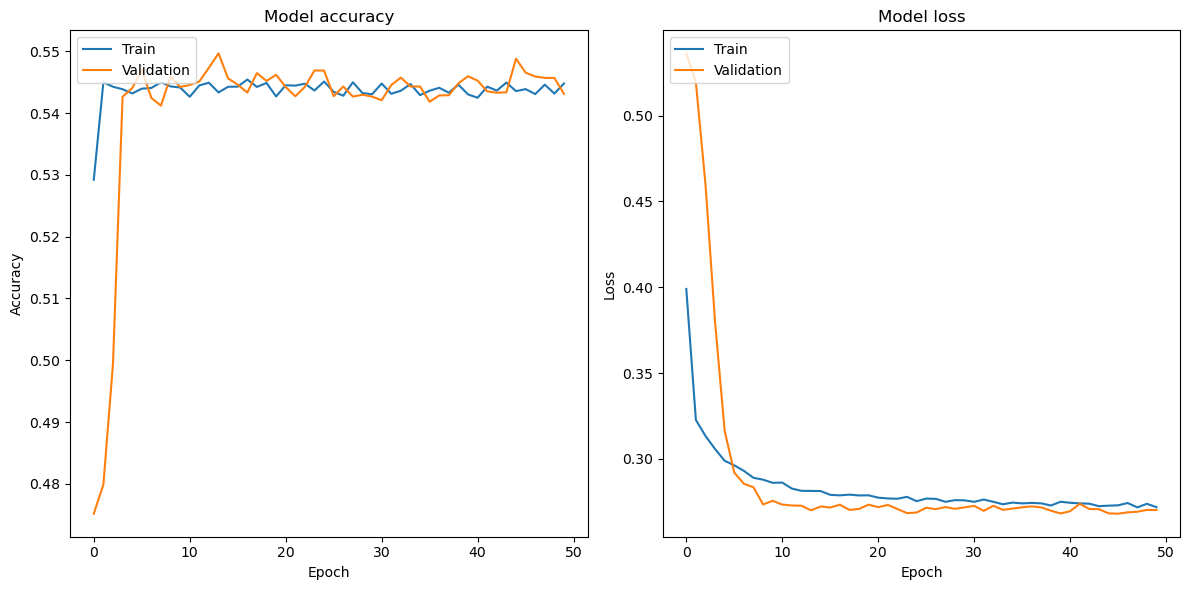

In [3]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)
